# Property appraisal ML project.
## Phase 0: researching and developing baseline simple ML algorithm to predict the prices of houses

### 1. Importing the model data: the first sheet of the Reference 3 F20 P1-1.xls file
### 2. Cleanup
### 3. Feature Engineering
### 4. Developoing a very simple ML model based on linear and random forest regressions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [2]:
# just reading the first sheet
df1 = pd.read_csv("0. F20 P1-Table 1.csv", na_values=['nan'])

# deleting yellow columns
df1.drop(['Status', 'For Tax Year', 'Gross Taxes', 'Original Price', 'List Price', 'GST Incl'], axis = 1, inplace = True)

# size of our dataset
print('Our dataset has', len(df1), 'data lines and', len(df1.columns.tolist()), 'features:')
print('\n')
print(df1.columns.tolist())

Our dataset has 558 data lines and 27 features:


['Address', 'distance', 'acessibility', 'S/A', 'Price', 'Sold Date', 'Days On Market', 'Age', 'Area', 'Total Bedrooms', 'Total Baths', 'Lot Sz (Sq.Ft.)', 'Floor Area -Grand Total', 'Driveway Finish', 'Floor Area - Unfinished', 'Foundation', 'Floor Area Fin - Basement', 'Zoning', 'Parking Places - Covered', '# Rms', 'No. Floor Levels', 'Frontage - Feet', 'Depth', 'Type', 'Unnamed: 30', 'Unnamed: 31', 'Public Remarks']


In [3]:
# dropping the columns with more than 90% NAs
moreThan = []

for feature in df1:
    if df1[feature].isna().sum() / df1.shape[0] > 0.9:
        moreThan.append(feature)
        print("Dropping the feature:", feature)
df1.drop(moreThan, axis = 1, inplace = True)

print('\n')

# dropping the columns that are not insightful: Days On Market, Public Remarks
df1.drop(['Sold Date', 'Public Remarks'], axis=1, inplace = True)

columns_names = df1.columns.tolist()

print("Features left:")
print(columns_names)
print('\n')
print("Now we have", len(columns_names), "features and their types:")

# types of our columns
pd.DataFrame(df1.dtypes, columns=['DataTypes'])

Dropping the feature: distance
Dropping the feature: acessibility
Dropping the feature: Unnamed: 30
Dropping the feature: Unnamed: 31


Features left:
['Address', 'S/A', 'Price', 'Days On Market', 'Age', 'Area', 'Total Bedrooms', 'Total Baths', 'Lot Sz (Sq.Ft.)', 'Floor Area -Grand Total', 'Driveway Finish', 'Floor Area - Unfinished', 'Foundation', 'Floor Area Fin - Basement', 'Zoning', 'Parking Places - Covered', '# Rms', 'No. Floor Levels', 'Frontage - Feet', 'Depth', 'Type']


Now we have 21 features and their types:


,DataTypes
Address,object
S/A,object
Price,object
Days On Market,int64
Age,int64
Area,object
Total Bedrooms,int64
Total Baths,int64
Lot Sz (Sq.Ft.),object
Floor Area -Grand Total,object


In [4]:
# the data is not cleaned!!! so we have to do something with that. 
# some features like Depth contain expressions like "99X44X32"

# a bit of cleanup

# in Address we need to take only the name of avenue 
df1['Address'] = df1['Address'].str.split(" ", 1).str[-1] 

# S/A nothing to do

# Price: remove $ and ,
df1['Price'] = df1['Price'].str.replace('$','')
df1['Price'] = df1['Price'].str.replace(',','')
df1['Price'] = df1['Price'].astype(float)
y = df1['Price']
# df1 = df1.drop(['Price'], axis=1)

# Days On Market nothing to do

# Age: delete outliers
df1['Age'][df1['Age'] > 100] == 0 ### or -1

# Area, Total Bedrooms, Total Baths: nothing to do

# Lot Sz (Sq.Ft.): remove , and .00
df1['Lot Sz (Sq.Ft.)'] = df1['Lot Sz (Sq.Ft.)'].str.replace(',', '')
df1['Lot Sz (Sq.Ft.)'] = df1['Lot Sz (Sq.Ft.)'].str.replace('.00', '')
df1['Lot Sz (Sq.Ft.)'] = df1['Lot Sz (Sq.Ft.)'].astype(float)

# Floor Area -Grand Total: remove ,
df1['Floor Area -Grand Total'] = df1['Floor Area -Grand Total'].str.replace(',', '')
df1['Floor Area -Grand Total'] = df1['Floor Area -Grand Total'].astype(float)

# Driveway Finish: replace nan's with Unknowns
df1['Driveway Finish'] = df1['Floor Area -Grand Total'].fillna('Unknown')

# Floor Area -Grand Total: remove ,
df1['Floor Area - Unfinished'] = df1['Floor Area - Unfinished'].str.replace(',', '')
df1['Floor Area - Unfinished'] = df1['Floor Area - Unfinished'].astype(float)

# Foundation: nothing to do

# Floor Area Fin - Basement: remove ,
df1['Floor Area Fin - Basement'] = df1['Floor Area Fin - Basement'].str.replace(',', '')
df1['Floor Area Fin - Basement'] = df1['Floor Area Fin - Basement'].astype(float)

# Zoning: maybe take a loot on intersection of two columns?!
df1['Zoning'] = df1['Zoning'].str.replace('1ACRER', 'RA')
df1['Zoning'] = df1['Zoning'].str.replace('1 AR', 'RA')
df1['Zoning'] = df1['Zoning'].str.replace('A1', 'A-1')
df1['Zoning'] = df1['Zoning'].str.replace('A2', 'A-2')
df1['Zoning'] = df1['Zoning'].str.replace('RF13', 'RF-13')
df1['Zoning'] = df1['Zoning'].str.replace('RHG', 'RH-G')
df1['Zoning'] = df1['Zoning'].str.replace('RS-1', 'RS1')
df1['Zoning'] = df1['Zoning'].str.replace('SING/F', 'SING')

# Parking Places - Covered: change nan's with 0 or -1
df1['Parking Places - Covered'] = df1['Parking Places - Covered'].fillna(0) ### or -1

# # Rms, No. Floor Levels: nothing to do

# Frontage - Feet: remove , and change nan with 0 oe -1
df1['Frontage - Feet'] = df1['Frontage - Feet'].str.replace(',', '')
df1['Frontage - Feet'] = df1['Frontage - Feet'].astype(float)
df1['Frontage - Feet'] = df1['Frontage - Feet'].fillna(0) ### or -1

# Depth: to work out!!!! now dropping
df1 = df1.drop(['Depth'], axis=1)

# Type: nothing to do 

# ooobj = df1['Depth']
# Counter(ooobj).keys()

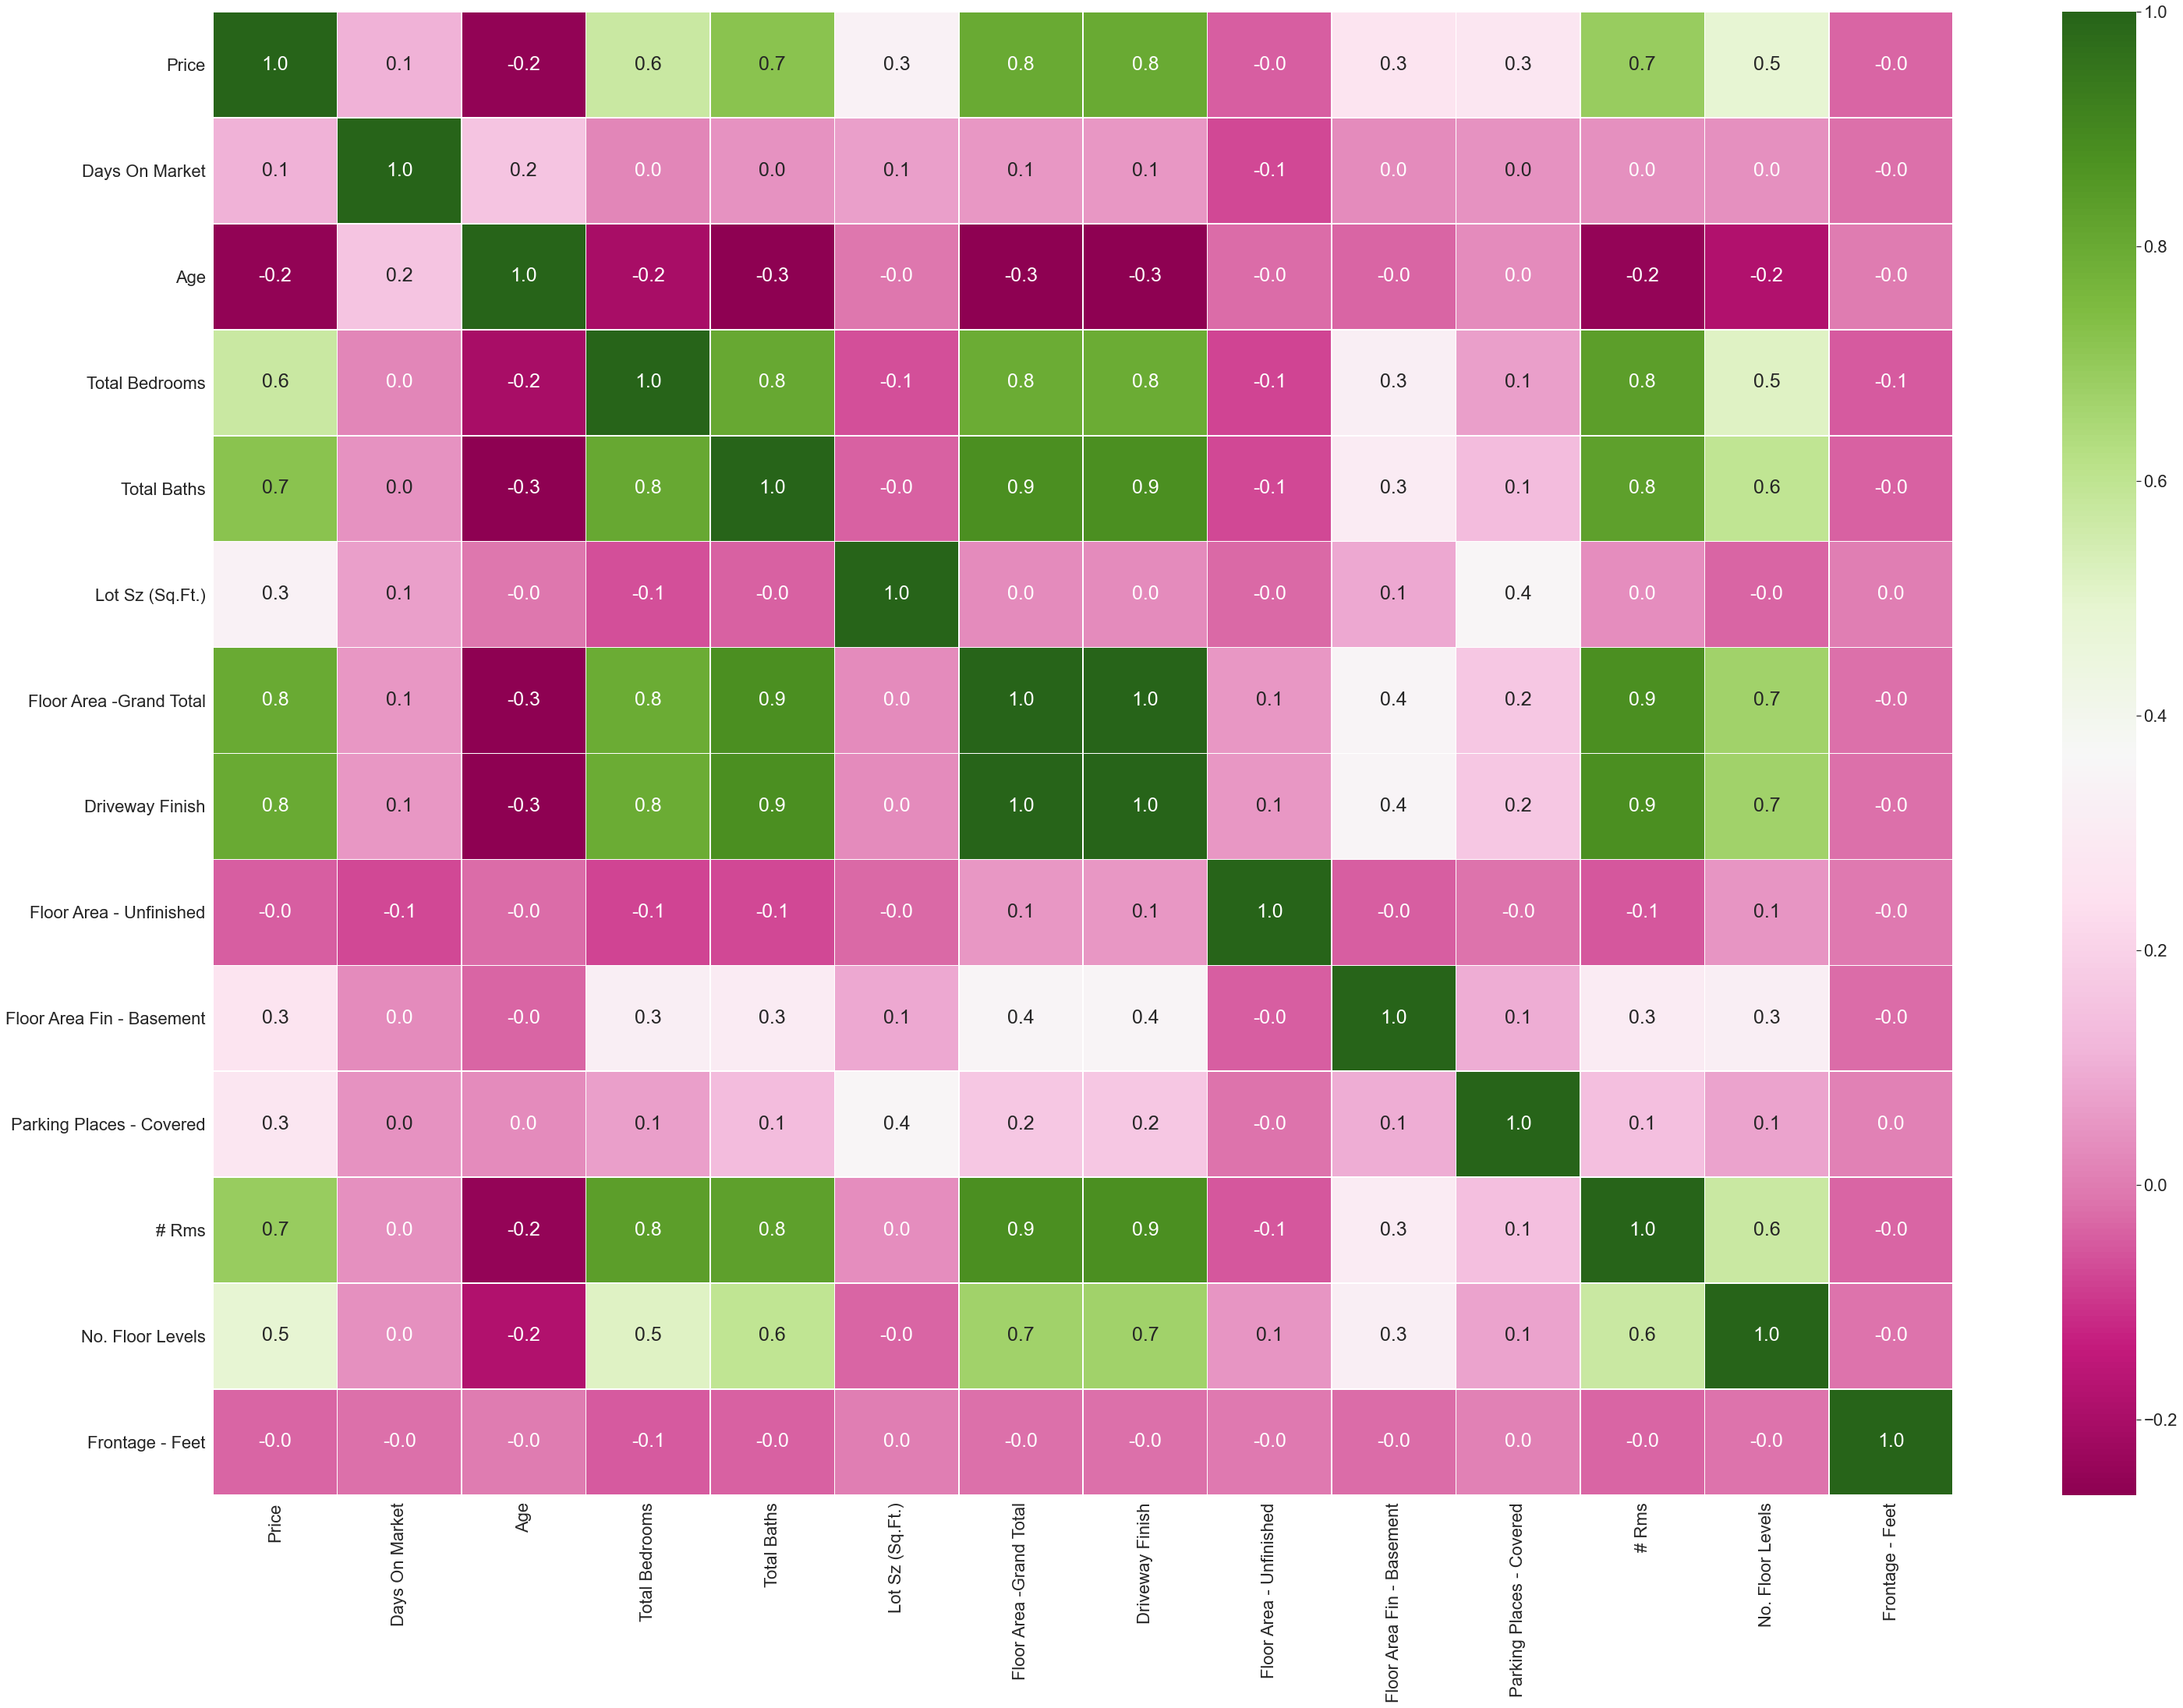

In [5]:
# calculating correlations between features to see what are the most interesting ones
correlation_df1 = df1.corr()
sb.set(font_scale=2)
plt.figure(figsize = (50,35))
ax = sb.heatmap(correlation_df1, annot=True,annot_kws={"size": 25},fmt='.1f',cmap='PiYG', linewidths=.5)

In [6]:
# one-hot-encoding categorical features
X1 = pd.get_dummies(df1[['Address', 'S/A', 'Area', 'Foundation', 'Zoning', 'Type']])

# preprocessing the price feature
y = df1['Price']
Y = np.log(y)

# making polynomial transformation of numerical features
X2 = df1.drop(['Address', 'S/A', 'Area', 'Foundation', 'Zoning', 'Type', 'Price'], axis = 1)
X2.fillna(0) ### or -1

poly = PolynomialFeatures(2)
X2_2 = poly.fit_transform(X2)

X2_3 = pd.DataFrame(X2_2, columns = poly.get_feature_names(X2.columns))
X2_3 = X2_3.drop(['1'], axis = 1)

# generating a big preprocessed dataset
X = pd.concat([X1, X2_3], axis = 1)

# rescaling it
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# norm = MinMaxScaler().fit(X)
norm = StandardScaler().fit(X)
X = pd.DataFrame(columns = X.columns, data = norm.transform(X))

# finally, we have 373 features
X.shape

(558, 373)

RMSE for linear regression: 60798.4797557799
RMSE for random forest regression: 66762.36888171604


weighted model: 0.2 * linear regressor + 0.8 random forest regressor
RMSE for weighted regressor: 58946.74343605945


plotting scatter plots between predicted and actual prices to see if out model is good:


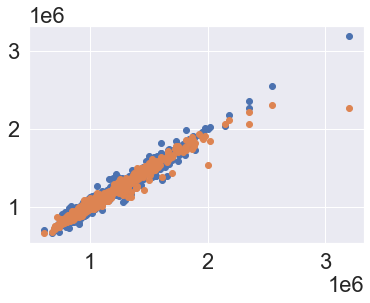

In [26]:
# let's make a simple linear regression on this

# calculate the logarithm of price
Y = np.log1p(y)

# LinearRegression model
lr = LinearRegression()
model_lr = lr.fit(X, Y)

predictions_lr = model_lr.predict(X)
print("RMSE for linear regression:", np.sqrt(mean_squared_error(y, np.expm1(predictions_lr))))

# RandomForest
rf = RandomForestRegressor(n_estimators=100)
model_rf = rf.fit(X, Y)

predictions_rf = model_rf.predict(X)
print("RMSE for random forest regression:", np.sqrt(mean_squared_error(y, np.expm1(predictions_rf))))


# let's take some weighted sum of these two regressions' predictions
weight_coeff = 0.2
predictions = (weight_coeff * predictions_lr + (1 - weight_coeff) * predictions_rf)
print('\n')
print("weighted model:", weight_coeff, "* linear regressor +", 1 - weight_coeff, "random forest regressor" )
print("RMSE for weighted regressor:", np.sqrt(mean_squared_error(y, np.expm1(predictions))))

# scatter plots
print('\n')
print("plotting scatter plots between predicted and actual prices to see if out model is good:")
plt.scatter(y, np.expm1(predictions_lr))
plt.scatter(y, np.expm1(predictions_rf))

In [29]:
# finally, let's check what we have
y_final = np.abs(np.expm1(predictions) - y)/(np.expm1(predictions)) * 100

final_matrix = [0, 0, 0, 0, 0]
for i in y_final:
    if i <= 2:
        final_matrix[0]+=1
    elif i <= 3:
        final_matrix[1]+=1
    elif i <= 5:
        final_matrix[2]+=1
    elif i <= 10:
        final_matrix[3]+=1
    else:
        final_matrix[4]+=1
        
for i in range(5):
    final_matrix[i] = np.round(final_matrix[i]/len(y_final) * 100, 1)
    
print("% of predictions accuracy: [<2%, 2 - 3%, 3 - 5%, 5 - 10%, >10%]")
print(final_matrix)
print('\n')
print("% of predictions, <=2% accuracy:", np.sum(final_matrix[:1]))
print("% of predictions, <=3% accuracy:", np.sum(final_matrix[:2]))
print("% of predictions, <=5% accuracy:", np.sum(final_matrix[:3]))
print("% of predictions, 5-10% accuracy:", np.sum(final_matrix[3]))
print("% of predictions,  >10% accuracy:", np.sum(final_matrix[4]))

% of predictions accuracy: [<2%, 2 - 3%, 3 - 5%, 5 - 10%, >10%]
[51.4, 15.4, 17.6, 12.9, 2.7]


% of predictions, <=2% accuracy: 51.4
% of predictions, <=3% accuracy: 66.8
% of predictions, <=5% accuracy: 84.4
% of predictions, 5-10% accuracy: 12.9
% of predictions,  >10% accuracy: 2.7


In [ ]:
# Main insight: very simple regressors are good for this type of data. 
# Let's go further and see if similarity ranking + NLP based algorithms could do better.